In [1]:
%run ./3_DATA_PREPARATION.ipynb

In [13]:
# https://youtu.be/tepxdcepTbY
"""
@author: Sreenivas Bhattiprolu
Code tested on Tensorflow: 2.2.0
    Keras: 2.4.3
dataset: https://finance.yahoo.com/quote/GE/history/
Also try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
"""

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

In [6]:
tmp = df.groupby(['Date','Store']).agg(Total_Sales = ('Weekly_Sales', 'sum') ).reset_index() # group by Store and aggregate the sum of the Weekly_Sales
top5 = tmp.sort_values(by=['Total_Sales'], ascending=False).head(5)['Store'].values # get top5 selling stores

#bring top 5 selling stores data
store14 = tmp.query('Store==14')
store20 = tmp.query('Store==20')
store10 = tmp.query('Store==20')
store4 = tmp.query('Store==20')
store13 = tmp.query('Store==20')

5773   2012-07-20
5818   2012-07-27
5863   2012-08-03
5908   2012-08-10
5953   2012-08-17
5998   2012-08-24
6043   2012-08-31
6088   2012-09-07
6133   2012-09-14
6178   2012-09-21
6223   2012-09-28
6268   2012-10-05
6313   2012-10-12
6358   2012-10-19
6403   2012-10-26
Name: Date, dtype: datetime64[ns]
['Total_Sales']
trainX shape == (129, 14, 1).
trainY shape == (129, 1).
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 14, 64)            16896     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
        

2022-09-10 09:20:17 tensorflow WARNING: 5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000013F2D330670> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 209ms/step


c:\Users\mike_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\mike_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Total_Sales'>

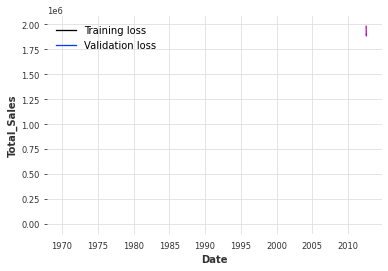

In [22]:
#Read the csv file
df = store14.drop('Store', axis=1)

#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

# df_for_plot=df_for_training.tail(5000)
# df_for_plot.plot.line()

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)


#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction).tolist()
print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Total_Sales':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Total_Sales']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['Total_Sales'])
sns.lineplot(df_forecast['Date'], df_forecast['Total_Sales'])